In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import warnings
warnings.filterwarnings('ignore')

In [ ]:
1 box plots

2 corr

3 scatters

4 pca 

In [27]:
path = "../data/all_salary_stats.csv"
df= pd.read_csv(path)
df.drop(columns=['Position(s)','Unnamed: 0','Unnamed: 0.1',
                 'First Name', 'Last Name', 'name', '_merge',
                 'Guaranteed Compensation'],inplace=True)
df.shape

(705, 103)

## need to write summary of cleaning steps below do all cleaning 

In [28]:

missing = [df.isnull().sum(),100*df.isnull().mean()]

m = pd.DataFrame(missing)
m = m.T
m.columns=['count', '%']
m = m.sort_values(by='count',ascending=False)
m.head()

,count,%
Base Salary,184.0,26.099291
Club,184.0,26.099291
dispossed,0.0,0.000000
Crosses,0.0,0.000000
Offsides,0.0,0.000000
Fouls_drawn,0.0,0.000000
Fouls,0.0,0.000000
Second_yellow,0.0,0.000000
Red_cards,0.0,0.000000
Yellow_cards,0.0,0.000000


1. DATA PROFILES — PLOTS AND TABLES
Reviewing summary statistics
Summary statistics can be evaluated via a summary statistics table and by checking the individual variable distribution plots. Both will indicate the spread of your data. Depending on the distribution, you may be able to infer the mean from distribution plots; however, the summary table is the best way to review this value. Compare the example summary statistics table and the histogram plots for reference.

In [7]:
#check amount of players per roster in data
df['Squad_from_op'].value_counts().head(5)

Toronto FC          30
Atlanta Utd         30
FC Cincinnati       28
D.C. United         28
Portland Timbers    28
Name: Squad_from_op, dtype: int64

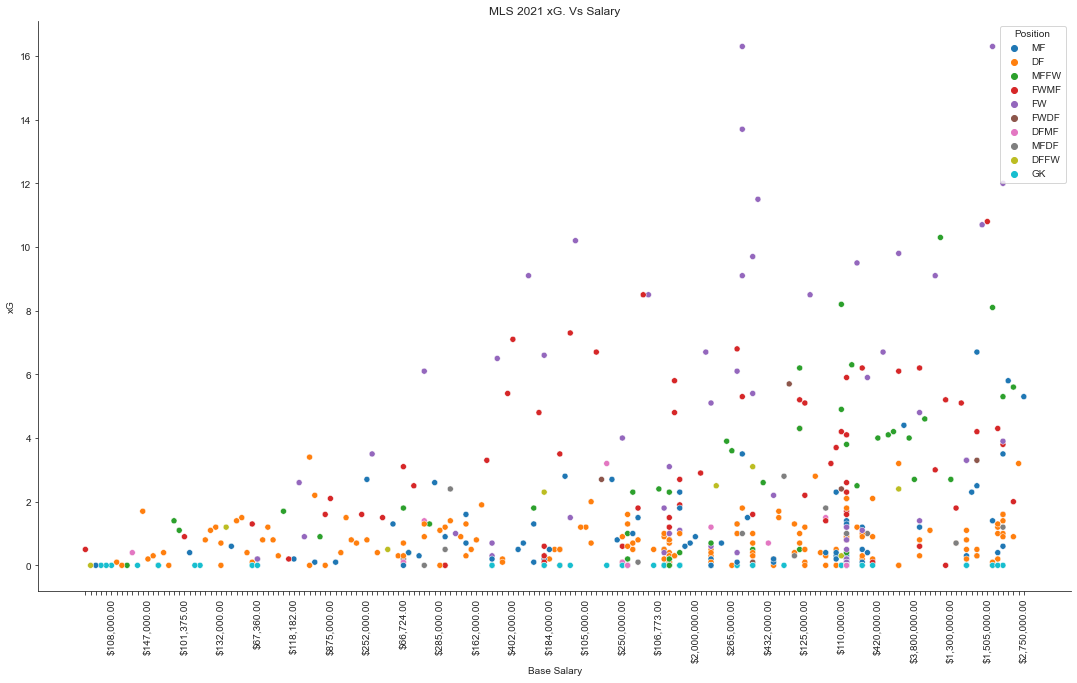

In [8]:
sns.set_style('ticks')

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

plt.gca().invert_xaxis()
plt.xticks(rotation = 90)
g = sns.scatterplot(data=df, x ='Base Salary', y='xG',hue='Position',
                    ax=ax).set(title='MLS 2021 xG. Vs Salary')

every_nth = 7
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
sns.despine()


## clean up position values

The positions categories in the data do not match the fb_ref documentation so I am choosing to map 'Position' to the simple three lines positional categories. 

In [9]:

## problem - positions like left wing , attacking mid, defensive mid , center back not given - columns filled with unclear values

# solution- remap values to clear basic over arching position values - other features will be used to cluster players on

# technique - iterate over unique position values and clean up into 3 categories as initial mixed up values not descriptive enough to keep

for i in df['Position'].unique():
  if i in ['FWMF','MFFW','MFDF','DFMF']:
    df['Position'] = df['Position'].str.replace(i,'MF')

  if i in ['FWDF', 'DFFW']:
    df['Position'] = df['Position'].str.replace(i,'FW')
    
df['Position'].value_counts()

MF    307
DF    227
FW    106
GK     65
Name: Position, dtype: int64

## reviewing xG graph redone after position mapping. 

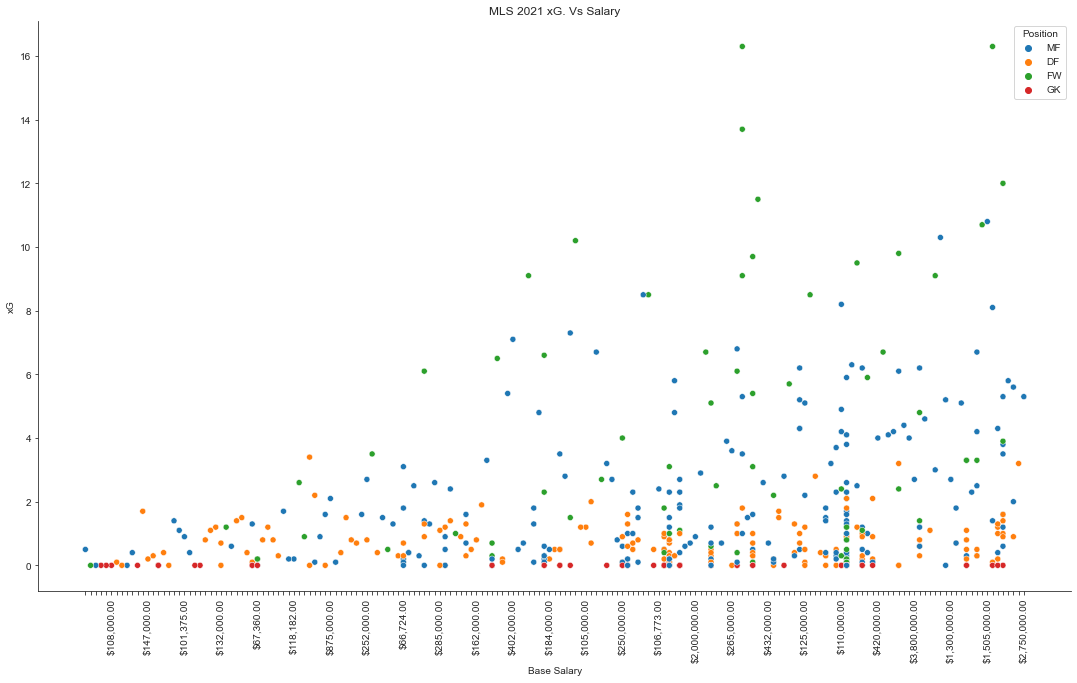

In [10]:
sns.set_style('ticks')

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

plt.gca().invert_xaxis()
plt.xticks(rotation = 90)
g = sns.scatterplot(data=df, x ='Base Salary', y='xG',hue='Position',
                    ax=ax).set(title='MLS 2021 xG. Vs Salary')
every_nth = 7
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
sns.despine()




## xA vs Salary 

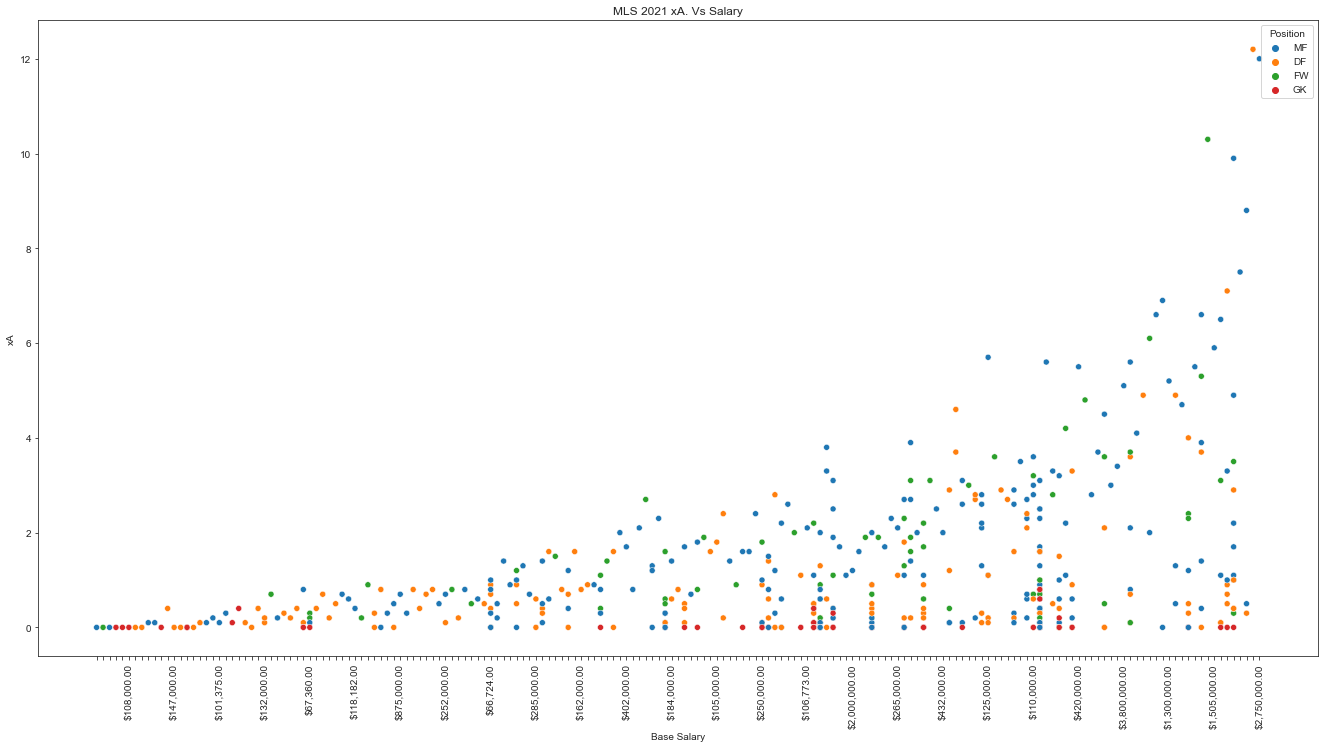

In [9]:
sns.set_style('ticks')

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

plt.gca().invert_xaxis()
plt.xticks(rotation = 90)

g = sns.scatterplot(data=df, x ='Base Salary', y='xA',hue='Position',
                ax=ax).set(title='MLS 2021 xA. Vs Salary')
               
every_nth = 7
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.tight_layout()


The above graph shows there is a clear positive corelation between Salary and expected Assists. There seems to be a clear you get what you pay for relationship between players who create assists. Some defenders and goalies do not follow this trend as there some some across the pay scale with no xA. 

## To be able to use the salary data in models I am remaping the values to intergers.


In [29]:
df['Base Salary'] = df['Base Salary'].str.replace('$','')
df['Base Salary'] = df['Base Salary'].str.replace(',','')
df['Base Salary'] = pd.to_numeric(df['Base Salary'])
df[['Base Salary']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Base Salary  521 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


<AxesSubplot:xlabel='Position', ylabel='Base Salary'>

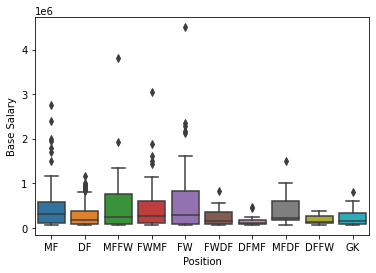

In [30]:
sns.boxplot(x ='Position', y='Base Salary',data=df)

##Insight - 
- We see 75 % of all position groups pay are below 100,000.
- There are more high paid Midfielders than any other position(shown as the outliers in the graph)  
- defenders and goal keepers have the lowest mean pay out of the groups. 

In [31]:
df = pd.read_csv('../data/final_per_90_and_pAdj.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 110 entries, fb_id to attacking_touches
dtypes: float64(101), int64(1), object(8)
memory usage: 606.0+ KB


## Feature vizual exploration 

- with the data now scaled to per 90 and possesion adjusted key features are to be visualised and observed below to looks for trends. 

In [32]:
# create defender only df 
defenders = df.loc[(df['Position']=='DF')&( df['Nineties'] >.9)]

In [ ]:
[ 'Comp_prog',
 'Total_Cmp',
    'Short_Cmp',
     'Medium_Cmp',
    'Long_Cmp',

    'avg_short+long_pass_pct',
 'Total_Cmp_pct',
    'Short_Cmp_pct',
    'Medium_Cmp_pct',
    'Long_Cmp_pct',
 
    'Total_Att',
 'Short_Att',
 'Medium_Att',
 'Long_Att']

In [ ]:
defenders['pct_long_balls']= defenders['ratio_long_balls']*100

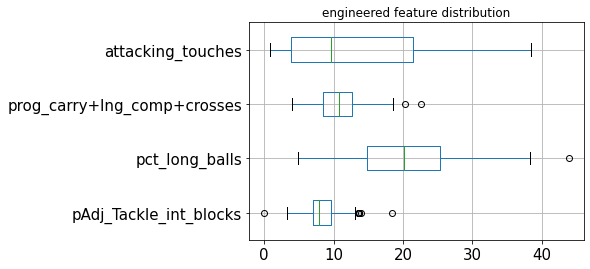

In [44]:
#use boxplot to observe outliers - key for anamoly dection 

boxplot = defenders[[
    # feature generated 
    'pAdj_Tackle_int_blocks','pct_long_balls','prog_carry+lng_comp+crosses','attacking_touches',

]].boxplot(grid = True,vert=False,fontsize=15).set(title='engineered feature distribution')
# plt.tight_layout()
plt.show()


In [51]:
corr = defenders[[
    # feature generated 
    'pAdj_Tackle_int_blocks','pct_long_balls','prog_carry+lng_comp+crosses','attacking_touches',

]].corr()

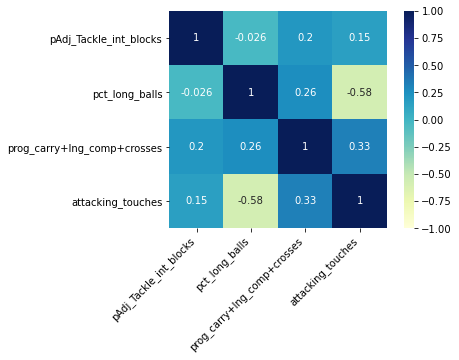

In [54]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
    cmap="YlGnBu",annot=True,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [47]:
#summary stats table transposed for df

# put higher up and show key features 
defenders[['pAdj_Tackle_int_blocks','avg_short+long_pass_pct','ratio_long_balls','prog_carry+lng_comp+crosses','attacking_touches']].describe().T

,count,mean,std,min,25%,50%,75%,max
pAdj_Tackle_int_blocks,216.0,8.222767,2.218654,0.000000,7.026797,7.932739,9.575002,18.429358
avg_short+long_pass_pct,216.0,88.923611,4.552875,66.300000,86.375000,89.200000,92.562500,100.000000
ratio_long_balls,216.0,0.203123,0.068585,0.048649,0.148808,0.201010,0.253467,0.438547
prog_carry+lng_comp+crosses,216.0,10.637414,2.987202,4.000000,8.450401,10.757467,12.694408,22.636364
attacking_touches,216.0,13.049039,9.927341,0.882353,3.863573,9.696970,21.482733,38.461538


# Passing features 

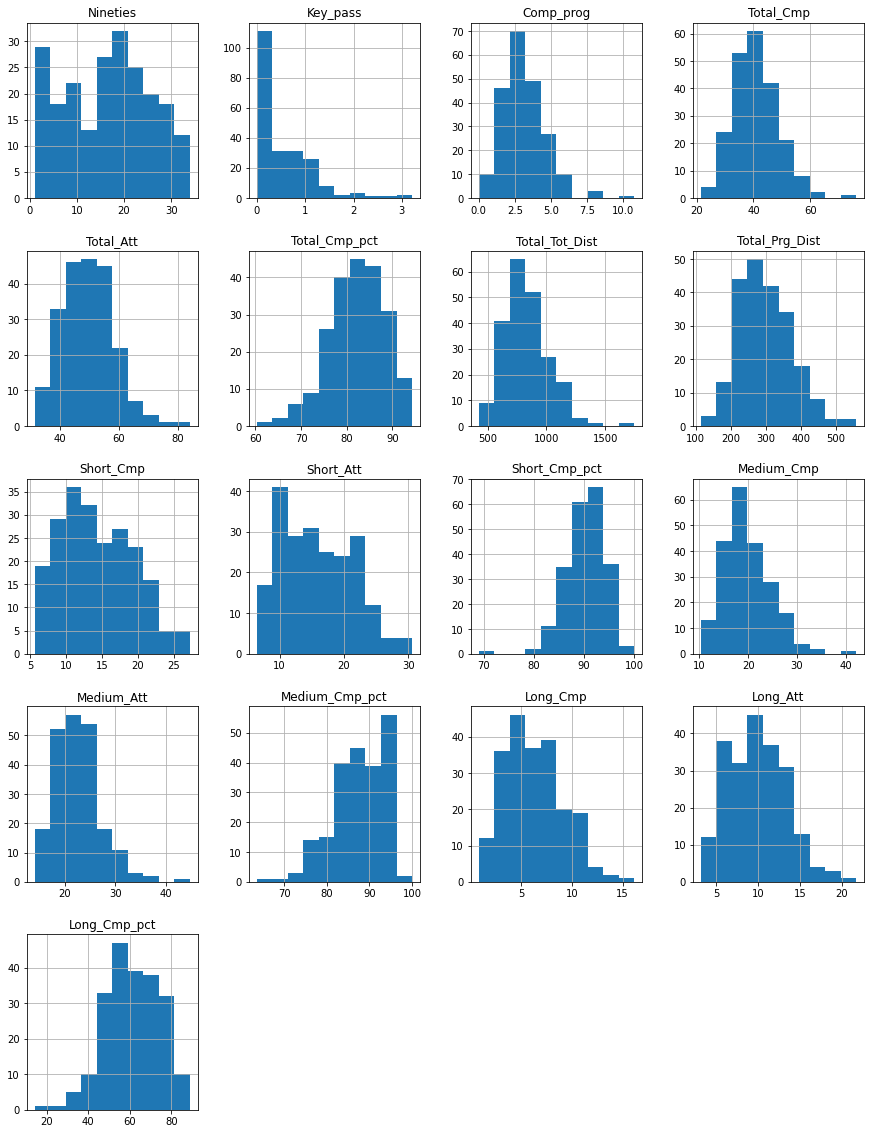

In [48]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
hist = defenders[['player_name',
 'Nineties',
 'Key_pass',
 'Comp_prog',
 'Total_Cmp',
 'Total_Att',
 'Total_Cmp_pct',
 'Total_Tot_Dist',
 'Total_Prg_Dist',
 'Short_Cmp',
 'Short_Att',
 'Short_Cmp_pct',
 'Medium_Cmp',
 'Medium_Att',
 'Medium_Cmp_pct',
 'Long_Cmp',
 'Long_Att',
 'Long_Cmp_pct']].hist(bins=10, ax=ax )


Passing attempt features have distinctly right tailed data and are skewed to the left,
 and passing pct features have left tails and are skewed to the right.

 Both of these observations are to be expected in the data as only few players will have a large amount of the different kind of attempts. There is also a basic threshold for completion percentage among players in the league for the various pass types. 

filering out players with less than 5 games could possibly change graphs. 

When comparing the completion pct features, long comp pct is the closest to being normally distributed. There are only a few players at the high completion percentages for long balls creating a left handed tail. The mode for short and medium pct due to is in the mid 90's while long balls are in the 50s. 
 

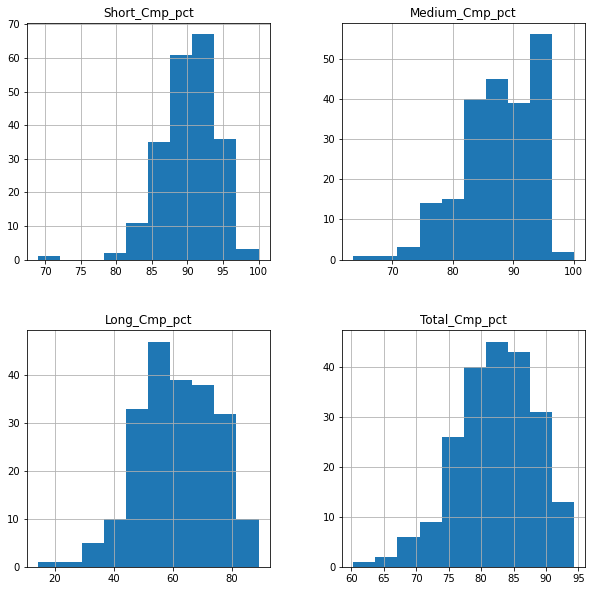

In [55]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
hist = defenders[['Short_Cmp_pct','Medium_Cmp_pct','Long_Cmp_pct','Total_Cmp_pct']].hist(bins=10,ax=ax)
plt.show()

In [39]:
passes = defenders[[
 'Opposing_Poss',
 'Opposing_Touches',
 'Nation',
 'Position',
 'xA',
 'Key_pass',
 'Comp_prog',
 'Total_Cmp',
 'Total_Att',
 'Total_Cmp_pct',
 'Total_Tot_Dist',
 'Total_Prg_Dist',
 'Short_Cmp',
 'Short_Att',
 'Short_Cmp_pct',
 'Medium_Cmp',
 'Medium_Att',
 'Medium_Cmp_pct',
 'Long_Cmp',
 'Long_Att',
 'Long_Cmp_pct']]

In [40]:
passes.corr().style.background_gradient(cmap="GnBu")

,Opposing_Poss,Opposing_Touches,xA,Key_pass,Comp_prog,Total_Cmp,Total_Att,Total_Cmp_pct,Total_Tot_Dist,Total_Prg_Dist,Short_Cmp,Short_Att,Short_Cmp_pct,Medium_Cmp,Medium_Att,Medium_Cmp_pct,Long_Cmp,Long_Att,Long_Cmp_pct
Opposing_Poss,1.000000,0.858622,-0.097323,-0.077250,-0.137456,-0.491350,-0.443527,-0.229944,-0.328481,-0.188278,-0.362482,-0.344165,-0.143829,-0.405098,-0.400427,-0.194624,-0.034104,0.017353,-0.068126
Opposing_Touches,0.858622,1.000000,-0.130717,-0.146598,-0.126645,-0.354493,-0.357688,-0.068336,-0.257761,-0.164781,-0.248001,-0.241457,-0.023149,-0.285517,-0.300708,-0.078205,-0.060816,-0.064489,-0.013408
xA,-0.097323,-0.130717,1.000000,0.889055,0.428500,0.030218,0.232390,-0.442752,-0.169688,0.023995,0.407704,0.444426,-0.291895,-0.235469,-0.111878,-0.478565,-0.253842,-0.082241,-0.332108
Key_pass,-0.077250,-0.146598,0.889055,1.000000,0.503662,0.099712,0.323491,-0.472388,-0.146430,0.055810,0.508296,0.539042,-0.261907,-0.210467,-0.075645,-0.497007,-0.281276,-0.075234,-0.403473
Comp_prog,-0.137456,-0.126645,0.428500,0.503662,1.000000,0.366326,0.576695,-0.387910,0.137127,0.415971,0.522902,0.540879,-0.197957,0.119810,0.304003,-0.462925,-0.119620,0.065203,-0.335224
Total_Cmp,-0.491350,-0.354493,0.030218,0.099712,0.366326,1.000000,0.927809,0.453680,0.837041,0.630820,0.538125,0.487977,0.459524,0.855625,0.884362,0.326451,0.378390,0.306000,0.258606
Total_Att,-0.443527,-0.357688,0.232390,0.323491,0.576695,0.927809,1.000000,0.095791,0.692623,0.629296,0.664411,0.641663,0.220578,0.687575,0.796259,0.005839,0.229347,0.305353,-0.037735
Total_Cmp_pct,-0.229944,-0.068336,-0.442752,-0.472388,-0.387910,0.453680,0.095791,1.000000,0.567572,0.175715,-0.123694,-0.204039,0.736473,0.623079,0.440661,0.876904,0.445954,0.083353,0.781606
Total_Tot_Dist,-0.328481,-0.257761,-0.169688,-0.146430,0.137127,0.837041,0.692623,0.567572,1.000000,0.731940,0.011858,-0.043162,0.493345,0.900045,0.854637,0.556609,0.805294,0.692383,0.568313
Total_Prg_Dist,-0.188278,-0.164781,0.023995,0.055810,0.415971,0.630820,0.629296,0.175715,0.731940,1.000000,0.105162,0.071046,0.276700,0.568097,0.594462,0.190886,0.616126,0.656359,0.287801


Expected Assists and short completions and sort attempts have a positive corelation of 0.58	and 0.61 respectivly. 
interestinly xA and short comp percent have .25 % negative correlation, this could point to trying to slot lots of short passes into dangerous areas that may not always be completed results in more expected assists than just lots of completed short passes that do not create shoring changes. Other features correlation to xA and xG can be followed up. 

In [ ]:
#summary stats table transposed for df
df.describe().T


hist = df.hist(bins=30, figsize=(10,10)


# workflow for catagorecial variables 
df_cat = df.select_dtypes(include='object').copy()

df_cat.col.value_counts()

sns.countplot(data=df_cat,x='colname')

#use boxplot to observe outliers - key for anamoly dection 

boxplot = df.boxplot(grid = False,vert=False,fontsize=15)



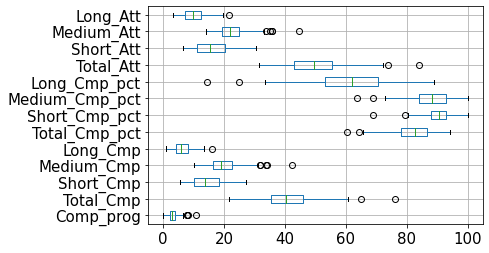

In [57]:
#use boxplot to observe outliers - key for anamoly dection 

boxplot = defenders[[
 'Comp_prog',
 'Total_Cmp',
    'Short_Cmp',
     'Medium_Cmp',
    'Long_Cmp',

 'Total_Cmp_pct',
    'Short_Cmp_pct',
    'Medium_Cmp_pct',
    'Long_Cmp_pct',
 
    'Total_Att',
 'Short_Att',
 'Medium_Att',
 'Long_Att']].boxplot(grid = True,vert=False,fontsize=15)


2. DATA RELATIONSHIPS
Investigating variable relationships through covariance matrices and other analysis methods is essential for not only evaluating the planned modeling strategy but also allows you to understand your data further. Below, we calculated the correlation coefficients for each variable in the data frame and then fed those correlations into a heatmap for ease of interpretation

In [ ]:
corr = df1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# ax = df.plot(kind='scatter',x='x',y='y')
# df[['x','y','lbl']].apply(lambda row: ax.text(*row),axis=1);

ax = df1.plot(kind='scatter',x='win/90', y ='GD' )
df1[['win/90','GD' ,'Squad']].apply(lambda row: ax.text(*row),axis=1)

In [ ]:
## viz group by columns 

spm.reindex(index=spm.mean(axis=1).sort_values(ascending=False).index).plot(
kind='barh',figsize=(10,10))
plt.xlabel('Price')


In [ ]:
2.6.3.5.2 Distribution of weekday and weekend price by state
Next, you can transform the data into a single column for price with a new categorical column that represents the ticket type.

#Code task 15#
#Use the pd.melt function, pass in the ski_data columns 'state', 'AdultWeekday', and 'Adultweekend' only,
#specify 'state' for `id_vars`
#gather the ticket prices from the 'Adultweekday' and 'AdultWeekend' columns using the `value_vars` argument,
#call the resultant price column 'Price' via the `value_name` argument,
#name the weekday/weekend indicator column 'Ticket' via the `var_name` argument
ticket_prices = pd.melt(ski_data[['state','AdultWeekday','AdultWeekend']], 
                        id_vars='state',
              var_name='Ticket',
              value_vars=['AdultWeekday','AdultWeekend'],
              value_name='Price')



This is now in a format we can pass to seaborn's boxplot function to create boxplots of the ticket price distributions for each ticket type for each state.

#Code task 16#
#Create a seaborn boxplot of the ticket price dataframe we created above,
#with 'state' on the x-axis, 'Price' as the y-value, and a hue that indicates 'Ticket'
#This will use boxplot's x, y, hue, and data arguments.
plt.subplots(figsize=(12, 8))
sns.boxplot(x='state', y='Price', hue='Ticket', data=ticket_prices)
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)')
plt.xlabel('State');

In [ ]:
plt.figure(10,12)
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu"annot=True)
plt.yticks(rotation=0)


# can also look at variable distributions and correlations with pairplots

g = sns.pairplot(df)



3. IDENTIFYING AND CREATING FEATURES
Variables and features are almost synonymous. The primary difference tends to be the context in which they are used; in machine learning, it is common practice to identify predictive features in your data whereas in parametric statistics, features are often referred to as variables and variables can include the response variable which you predict with your model.

The goal of identifying features is to use your exploratory work to isolate features that will be most helpful in constructing a predictive model. In addition to recognizing those features, it often behooves one to create additional features for inclusion in your predictive modeling work.
Once you have identified the critical features for your model development, you may realize you need to create additional features to augment your original data. You can do this through the development of combining features or revaluing them to emphasize specific relationships. Additional features can also be created through Principal Components Analysis or Clustering.

Building a Principle Components Analysis (PCA) is a useful way to apply a dimension reduction application to identify which features contain the most amount of variation within your development dataset. The predictive model can be constructed on the principal components themselves as features, resulting in feature reduction. Feature reduction is helpful when your data set has too many features to choose from, and you need a more automated way to reduce the number of input features for modeling. There are different flavors of dimension reduction methods based on multi-dimensional scaling, such as Principal Coordinate Analysis. Lasso regression is another tool for a semi-automated feature selection approach. Review these methods to determine the best strategy for your project.


Clustering (e.g. K-means clustering) is an excellent exploratory analysis method for creating additional features which in this case would be the clusters themselves. The clusters can be used in conjunction with additional features if you find them to be valid after review.